# PortfolioBuilder

### Purpose
This Jupyter Notebook is specifically designed to analyze the financial performance and health of selected companies with the goal of determining their potential value as additions to an investment portfolio. By examining key financial metrics and trends, this notebook aims to provide an in-depth understanding and a data-driven approach to aid in making informed investment decisions. The analysis will cover various financial aspects including profitability, liquidity, and growth potential, which are critical for assessing whether a company stands as a promising investment opportunity.


### How to Use This Notebook
To use this notebook effectively, you will need to set up a specific Python environment which includes all the necessary libraries and their dependencies. Follow these steps to prepare your environment:

#### Step 1: Clone the Repository
If applicable, clone the repository containing this notebook and associated files (like the environment file) to your local machine using:
```bash
git clone [URL-to-your-repository]
```

#### Step 2: Create the env
Use the following commands to create and activate the Conda environment from the YAML file included in the directory `conda`:
```bash
cd conda
conda env create -f notebooks_portfolio_builder.yml
```

#### Step 3: Activating the env
```bash
conda activate portfolio_builder
```

### Author
- Name: Mauro Andretta
- Date Created: 2024/07/25
- Contact: mauo.andretta222@gmail.com

In [47]:
# Import necessary libraries
import yfinance as yf
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter
import pandas as pd
import os
import time

# array operations
import numpy as np

# read config file
import configparser

# progress bar
import pyprind

# visualize
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [48]:
# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the config.ini file
config.read('config.ini')

# Retrieve the paths from the config file
csv_folder = config.get('Paths', 'csv_folder')

# check if the csv and excel folder exists
# if not create them
try:
    if not os.path.exists(csv_folder):
        os.makedirs(csv_folder)
        print(f"Directory {csv_folder} created")
    else:
        print(f"Directory {csv_folder} already exists")
    
except Exception as e:
    print(f"An error occurred: {e}")

Directory companies_data/csv_files already exists


# Fetch stock data

In [49]:
def save_company_data_to_csv(ticker_symbol: str, company_data: dict, root_dir: str, period: str) -> None:
    """
    This function takes a stock ticker as input and saves the company data to a CSV file.
    Args:
        ticker_symbol (str): The stock ticker of the company for which the data is to be fetched.
        company_data (dict): A dictionary containing different types of financial data for the given stock ticker.
        root_dir (str): The root directory where the data will be saved.
        period (str): The period for which the data is to be fetched (e.g., '1d', '1mo', '1y', '5y', etc.).
    """

    # Create the root directory if it does not exist
    if not os.path.exists(root_dir):
        os.makedirs(root_dir)

    # Create a directory for the company if it does not exist
    company_dir = os.path.join(root_dir, period, ticker_symbol)
    if not os.path.exists(company_dir):
        os.makedirs(company_dir)

    # Iterate over the dictionary and save each item to a CSV file
    for key, value in company_data.items():
        if isinstance(value, pd.DataFrame):
            file_path = os.path.join(company_dir, f"{key}.csv")
            value.to_csv(file_path)
            #print(f"Saved {key}.csv in {company_dir}/")
    
    

In [50]:
def get_company_data(ticker_symbol: str, period: str = "1y") -> dict:
    """
    This function takes a stock ticker as input and returns a dictionary containing different types of financial data.

    Parameters:
    ticker (str): The stock ticker of the company for which the data is to be fetched.
    period (str): The period for which the data is to be fetched. It can be one of the following options: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max.

    Returns:
    dict: A dictionary containing different types of financial data for the given stock ticker.
    """
    # check if the period is valid
    if period not in ["1d", "5d", "1mo", "3mo", "6mo", "1y", "2y", "5y", "10y", "ytd", "max"]:
        raise ValueError("Invalid period. Please enter a valid period from the following options: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max")
    
    try:
        # get all stock info
        company = yf.Ticker(ticker_symbol)
        
        # get historical market data
        info = company.info

        # show meta information about the history 
        historical_data = company.history(period=period)
        actions = company.actions
        dividends = company.dividends
        splits = company.splits
        capital_gains = company.capital_gains

        # show financials:
        # - financials
        financials = company.financials
        quarterly_financials = company.quarterly_financials
        # - income statement
        income_stmt = company.income_stmt
        quarterly_income_stmt = company.quarterly_income_stmt
        # - balance sheet
        balance_sheet = company.balance_sheet
        quarterly_balance_sheet = company.quarterly_balance_sheet
        # - cash flow statement
        cashflow = company.cashflow
        quarterly_cashflow = company.quarterly_cashflow


        sustainability = company.sustainability
        recommendations = company.recommendations
        calendar = company.calendar
        news = company.news
        isin = company.isin

        # Store data in a dictionary
        data = {
            "info": info,

            "historical_data": historical_data,

            "actions": actions,
            "dividends": dividends,
            "splits": splits,
            "capital_gains": capital_gains,

            "financials": financials,
            "quarterly_financials": quarterly_financials,
            "income_stmt": income_stmt,
            "quarterly_income_stmt": quarterly_income_stmt,
            "balance_sheet": balance_sheet,
            "quarterly_balance_sheet": quarterly_balance_sheet,
            "cashflow": cashflow,
            "quarterly_cashflow": quarterly_cashflow,

            "sustainability": sustainability,
            "recommendations": recommendations,
            "calendar": calendar,
            "news": news,
            "isin": isin
        }

    except Exception as e:
        print(f"An error occurred: {e}")
        print(f"Could not fetch data for {ticker_symbol}")
        print("The data for this company will not be saved.")
        data = None
    
    return data

In [57]:
# add a try except block to catch any errors
tickers = ["TCEHY", "HSBC", "RTX", "ROG.SW", "SSNLF", "TM", "UL", "NVDA", "QBE.AX", 
          "RIO", "MHR.SG", "RMS.PA", "ESLOY", "SPOT", "WMT", "ENR.DE", "ABNB", "BAYN.DE", "MMM", "EL.PA", "AMZN"]
range_analysis = "1y" # valid options are: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max


In [52]:
def fetch_ticker_data(ticker_symbols: list, period: str) -> None:
    """
    Fetches data for a list of stock tickers.
    Args:
        ticker_symbols (list): A list of stock tickers for which the data is to be fetched.
        period (str): The period for which the data is to be fetched (e.g., '1d', '1mo', '1y', '5y', etc.).
    """
    print(f"Fetching data for {ticker_symbols} companies!")
    bar = pyprind.ProgBar(len(ticker_symbols), track_time=False, title='fetching data for companies')

    try:
        # check first if the information for the company is already in the csv folder
        # given the period
        for ticker_symbol in ticker_symbols:
            company_dir = os.path.join(csv_folder, period, ticker_symbol)
            if os.path.exists(company_dir):
                print(f"Data for {ticker_symbol} already exists!")
                bar.update()
                continue

            else:
                print(f"Fetching data for {ticker_symbol}...")
                # Get the data for the company
                company_data = get_company_data(ticker_symbol, period)
                print(f"Data fetched for {ticker_symbol}")

                # Check if the company data is None
                if company_data is None:
                    print(f"Could not fetch data for {ticker_symbol}")
                    print("The data for this company will not be saved.")
                    continue

                # Save the company data to a CSV file
                save_company_data_to_csv(ticker_symbol, company_data, csv_folder, period)
                print(f"Data saved for {ticker_symbol}")
                bar.update()

    except Exception as e:
        print(f"An error occurred while extracting companies' financial info: {e}")
        # If there's a general error not caught by specific handlers, handle it here

In [53]:
# fetch the stocks data
fetch_ticker_data(tickers, range_analysis)

fetching data for companies


Fetching data for ['TCEHY', 'HSBC', 'RTX', 'ROG.SW', 'SSNLF', 'TM', 'UL', 'NVDA', 'QBE.AX', 'RIO', 'MHR.SG', 'RMS.PA', 'ESLOY', 'SPOT', 'WMT', 'ENR.DE', 'ABNB', 'BAYN.DE', 'MMM', 'EL.PA', 'AMZN'] companies!


0% [#################### ] 100%

Data for TCEHY already exists!
Data for HSBC already exists!
Data for RTX already exists!
Data for ROG.SW already exists!
Data for SSNLF already exists!
Data for TM already exists!
Data for UL already exists!
Data for NVDA already exists!
Data for QBE.AX already exists!
Data for RIO already exists!
Data for MHR.SG already exists!
Data for RMS.PA already exists!
Data for ESLOY already exists!
Data for SPOT already exists!
Data for WMT already exists!
Data for ENR.DE already exists!
Data for ABNB already exists!
Data for BAYN.DE already exists!
Data for MMM already exists!
Data for EL.PA already exists!
Fetching data for AMZN...


0% [#####################] 100%

Data fetched for AMZN
Data saved for AMZN


# Historichal data stocks analysis

In [54]:
# Loop over all the compaines in the companies/csv_files folder
# For each company, read the historical_data.csv as a DataFrame
# Create a new column in the DataFrame called "Returns" basedon the "Close" column
# Save the new created column to a new DataFrame with a column equal to the comapny name
# and values equal to the "Close Price Percentage Change" column
# Once all the company have been analysed, create the covariance and correlation matrix of the new DataFrame

def calculate_cov_corr_matrices(tickers: list, csv_folder: str, period: str = "1y", 
                                return_type: str = "simple") -> None:
    """
    This function calculates the correlation matrix of the percentage change in closing prices of different companies.

    Args:
        tickers (list): A list of company names for which the correlation matrix is to be calculated.
        csv_folder (str): The path to the folder containing the historical data CSV files.
        return_type (str): The type of returns to be calculated. It can be either "simple" or "log".
        companies (list): A list of company names for which the correlation matrix is to be calculated.
        period (str): The period for which the data is to be fetched (e.g., '1d', '1mo', '1y', '5y', etc.).
    """
    # Create an empty dictionary to store the percentage change in closing prices for each company
    returns_data= {}

    # Loop over all the companies in the CSV folder
    for subdir, _, files in os.walk(os.path.join(csv_folder, period)):
        for file in files:
            if file.endswith("historical_data.csv"):

                # Extract the company name from the file path
                company_name = os.path.basename(subdir)

                # if the company name is not in the tickers list, skip it
                if company_name not in tickers:
                    continue
                else:
                    # Construct the file path
                    file_path = os.path.join(subdir, file)
                    
                    # Read the historical data CSV file
                    df = pd.read_csv(file_path)

                    # Ensure the DataFrame has the necessary columns
                    if "Close" not in df.columns:
                        print(f"Missing 'Close' column in {file_path}")
                        continue

                    if return_type == "simple":
                        # Calculate the returns based on the closing prices
                        df["Returns"] = df["Close"].pct_change() * 100
                    elif return_type == "log":
                        # Calculate the log returns based on the closing prices
                        df["Log Returns"] = np.log(df["Close"] / df["Close"].shift(1))
                    else:
                        print("Invalid return type. Please choose either 'simple' or 'log'.")
                        return None, None

                    # Store the returns in the dictionary
                    if return_type == "simple":
                        returns_data[company_name] = df["Returns"]
                    elif return_type == "log":
                        returns_data[company_name] = df["Log Returns"]


    # Create a DataFrame from the dictionary
    returns_df = pd.DataFrame(returns_data)
    returns_df = returns_df.dropna()
    
    # Calculate the covariance matrix
    covariance_matrix = returns_df.cov()
    correlation_matrix = returns_df.corr()
    

    return covariance_matrix, correlation_matrix

In [55]:
# Example usage
cov_matrix, corr_matrix = calculate_cov_corr_matrices(tickers, csv_folder, period= "1y", return_type="simple")


In [76]:
corr_matrix

,ABNB,AMZN,BAYN.DE,EL.PA,ENR.DE,ESLOY,HSBC,MHR.SG,MMM,NVDA,...,RIO,RMS.PA,ROG.SW,RTX,SPOT,SSNLF,TCEHY,TM,UL,WMT
ABNB,1.000000,0.373340,0.081317,0.116404,0.066725,0.260153,0.178391,0.030226,0.174711,0.315290,...,0.223552,-0.019863,0.062038,-0.006244,0.229445,0.068298,0.190324,0.342292,0.062654,0.097778
AMZN,0.373340,1.000000,0.092204,0.029900,-0.115230,0.276895,0.107850,-0.077663,0.063092,0.452957,...,0.227938,-0.093499,-0.086572,0.022546,0.372704,0.088801,0.192983,0.241599,-0.017002,0.117392
BAYN.DE,0.081317,0.092204,1.000000,0.211755,0.192553,-0.017526,0.035377,0.045811,0.126688,0.107787,...,-0.028759,0.176840,0.115892,-0.005318,0.101642,0.026164,0.076292,0.025781,-0.058271,-0.073524
EL.PA,0.116404,0.029900,0.211755,1.000000,0.244375,0.010155,0.073483,0.002723,0.150967,0.128684,...,0.016339,0.536239,0.057504,0.012791,-0.077056,0.025464,0.040812,-0.030982,0.100399,0.051180
ENR.DE,0.066725,-0.115230,0.192553,0.244375,1.000000,-0.054949,0.078667,0.042864,0.103900,0.036308,...,0.019235,0.222816,0.020425,0.029790,-0.035985,0.008466,0.032680,-0.009335,0.210043,0.021168
ESLOY,0.260153,0.276895,-0.017526,0.010155,-0.054949,1.000000,0.261171,0.001584,0.316215,0.209874,...,0.376340,-0.041907,0.140825,0.137454,0.176723,0.089781,0.222493,0.217252,0.309108,0.028618
HSBC,0.178391,0.107850,0.035377,0.073483,0.078667,0.261171,1.000000,-0.018744,0.181452,0.194974,...,0.373871,0.048312,0.037687,0.059297,0.127386,-0.000730,0.242921,0.241458,0.193371,0.110101
MHR.SG,0.030226,-0.077663,0.045811,0.002723,0.042864,0.001584,-0.018744,1.000000,-0.012477,0.028553,...,0.017275,0.099201,0.115332,0.004929,-0.032949,0.122306,0.013940,-0.054585,0.100797,-0.045706
MMM,0.174711,0.063092,0.126688,0.150967,0.103900,0.316215,0.181452,-0.012477,1.000000,0.000994,...,0.226363,0.094267,0.106183,0.040995,0.045343,-0.008747,0.099897,0.012029,0.236935,0.059039
NVDA,0.315290,0.452957,0.107787,0.128684,0.036308,0.209874,0.194974,0.028553,0.000994,1.000000,...,0.161003,-0.019513,-0.010510,-0.060126,0.321269,0.018888,0.220017,0.196048,0.022510,-0.023684


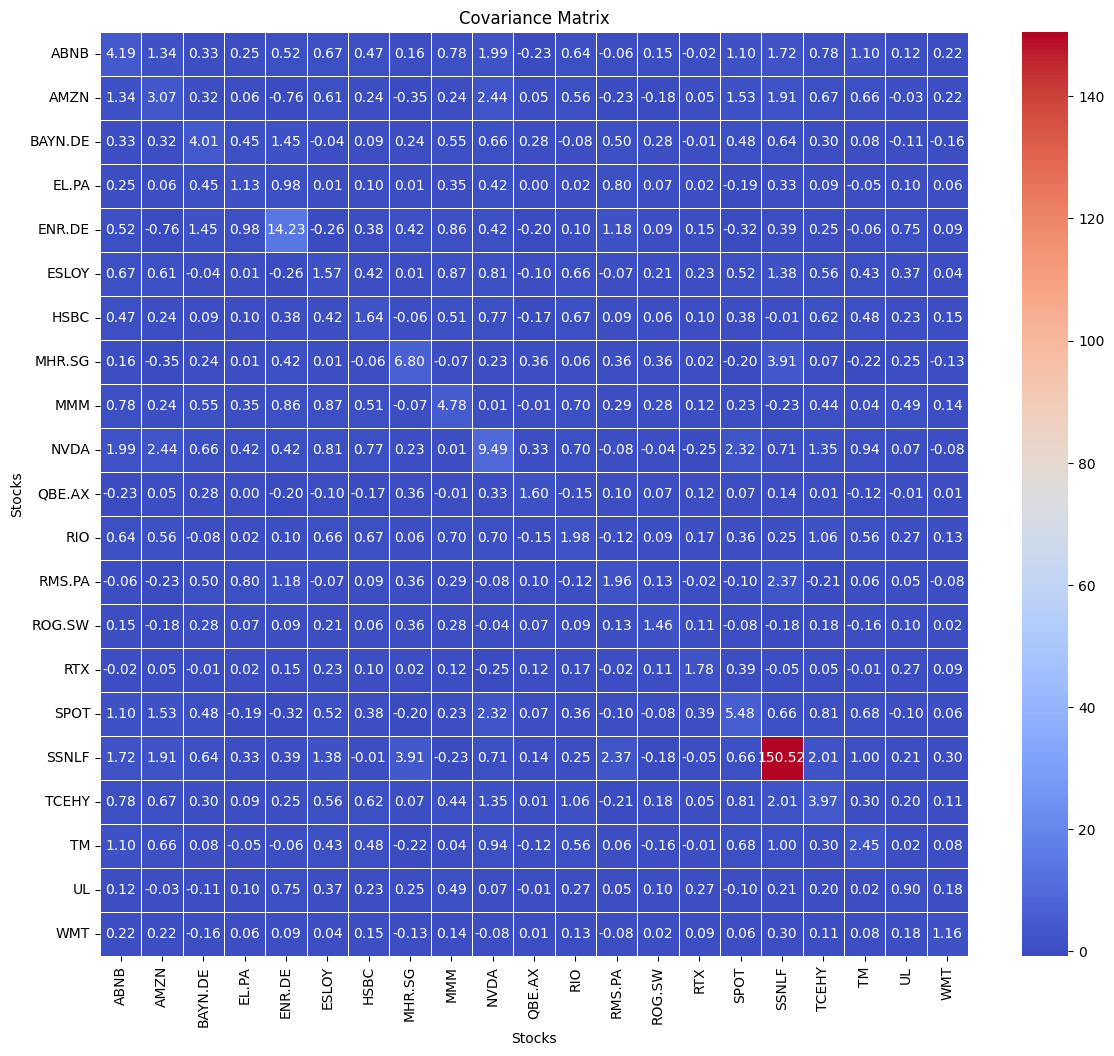

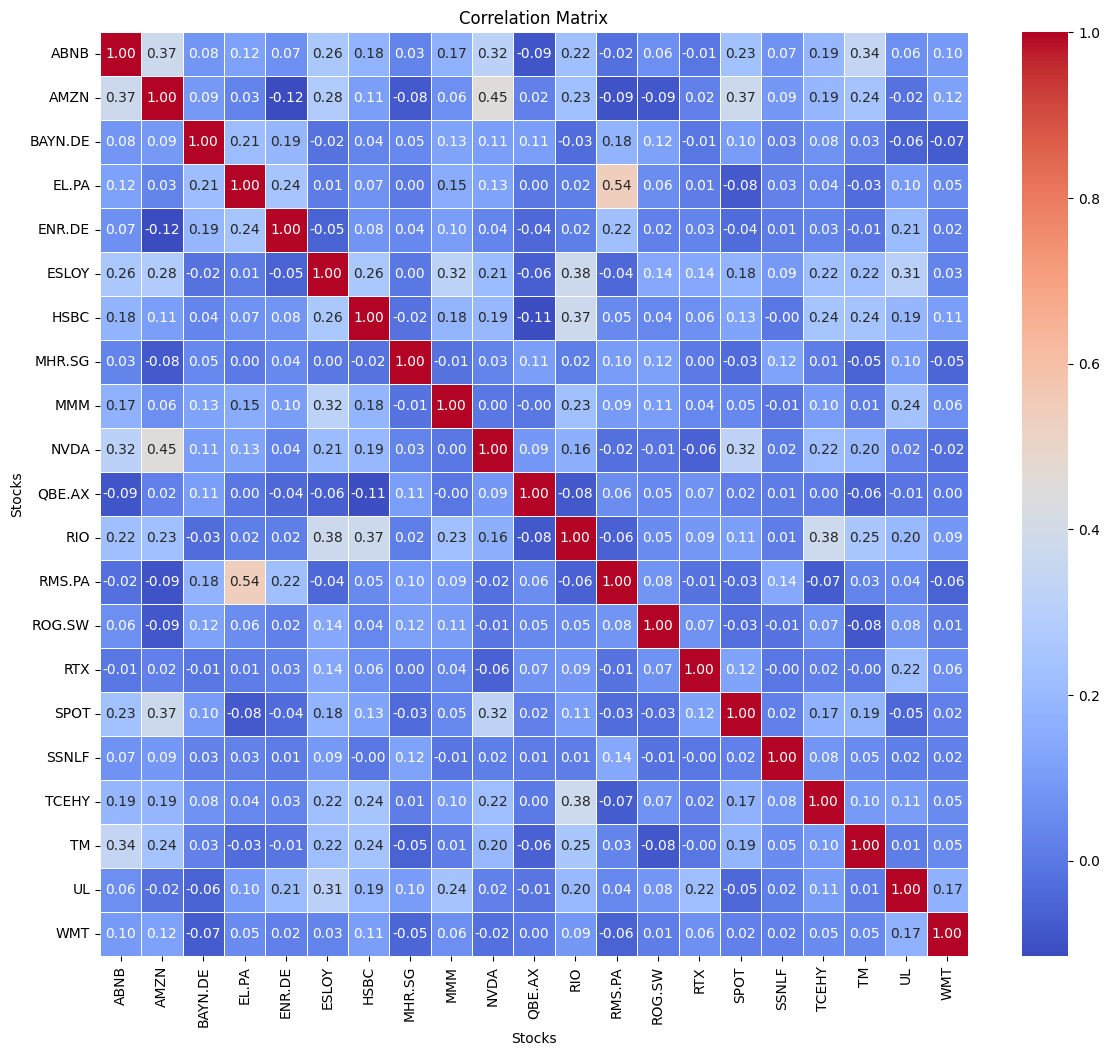

In [56]:
def plot_heatmap(matrix: pd.DataFrame, title: str) -> None:
    """
    This function plots a heatmap of the given matrix.

    Args:
        matrix (pd.DataFrame): The matrix to be plotted.
        title (str): The title of the plot.
    """
    # Create a heatmap
    plt.figure(figsize=(14, 12))  
    # Create a heatmap plot
    sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    
    # Set the title of the plot
    plt.title(title)
    plt.xlabel('Stocks')
    plt.ylabel('Stocks')
    
    # Display the plot
    plt.show()

# Plot the covariance matrix
#plot_heatmap(cov_matrix, "Covariance Matrix")
# Plot the correlation matrix
plot_heatmap(corr_matrix, "Correlation Matrix")

In [81]:
# Method to find the minimum edge weight in the graph
def find_minimum_weight(G):
    # Extract all weights from the graph into a list
    weights = [data['weight'] for u, v, data in G.edges(data=True)]
    # Find the minimum weight
    min_weight = min(weights) if weights else None
    return min_weight

def create_graph_from_correlation(corr_matrix: pd.DataFrame) -> None:
    """
    This function creates a network graph based on the correlation matrix.

    Args:
        corr_matrix (pd.DataFrame): The correlation matrix of the stock returns.
    """
    G = nx.Graph()

    # Add nodes and edges with weights based on correlation
    for i in corr_matrix.columns:
        for j in corr_matrix.columns:
            if i != j:
                weight = corr_matrix.loc[i, j]
                if abs(weight) > 0.3:  # Add an edge if correlation is significant
                    G.add_edge(i, j, weight=weight)

    # Create a figure and axes for the network graph
    fig, ax = plt.subplots(figsize=(12, 10))

    # Use a spring layout with a custom k parameter for optimal spacing
    pos = nx.spring_layout(G, seed=42, k=10)

    # Extract edges and their weights for coloring and styling
    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

    # Normalize edge widths for better visibility
    edge_widths = [(5.0 * abs(w)) for w in weights]

    # Draw nodes with enhanced size and color
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=600, alpha=0.9, ax=ax)

    # Draw edges with color based on weight
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=weights, edge_cmap=plt.cm.coolwarm, width=edge_widths, ax=ax)

    # Draw node labels with customized font properties
    nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold', font_color='black', ax=ax)

    # Draw edge labels (weights) with larger size and black color
    edge_labels = {(i, j): f'{weight:.2f}' for i, j, weight in G.edges(data='weight')}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=14, ax=ax)

    # Add a color bar to indicate correlation strength
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=find_minimum_weight(G), vmax=1))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Correlation Strength')

    ax.set_title('Network Graph of Stock Correlations', fontsize=16)
    ax.axis('off')  # Turn off the axis
    plt.tight_layout()
    plt.show()

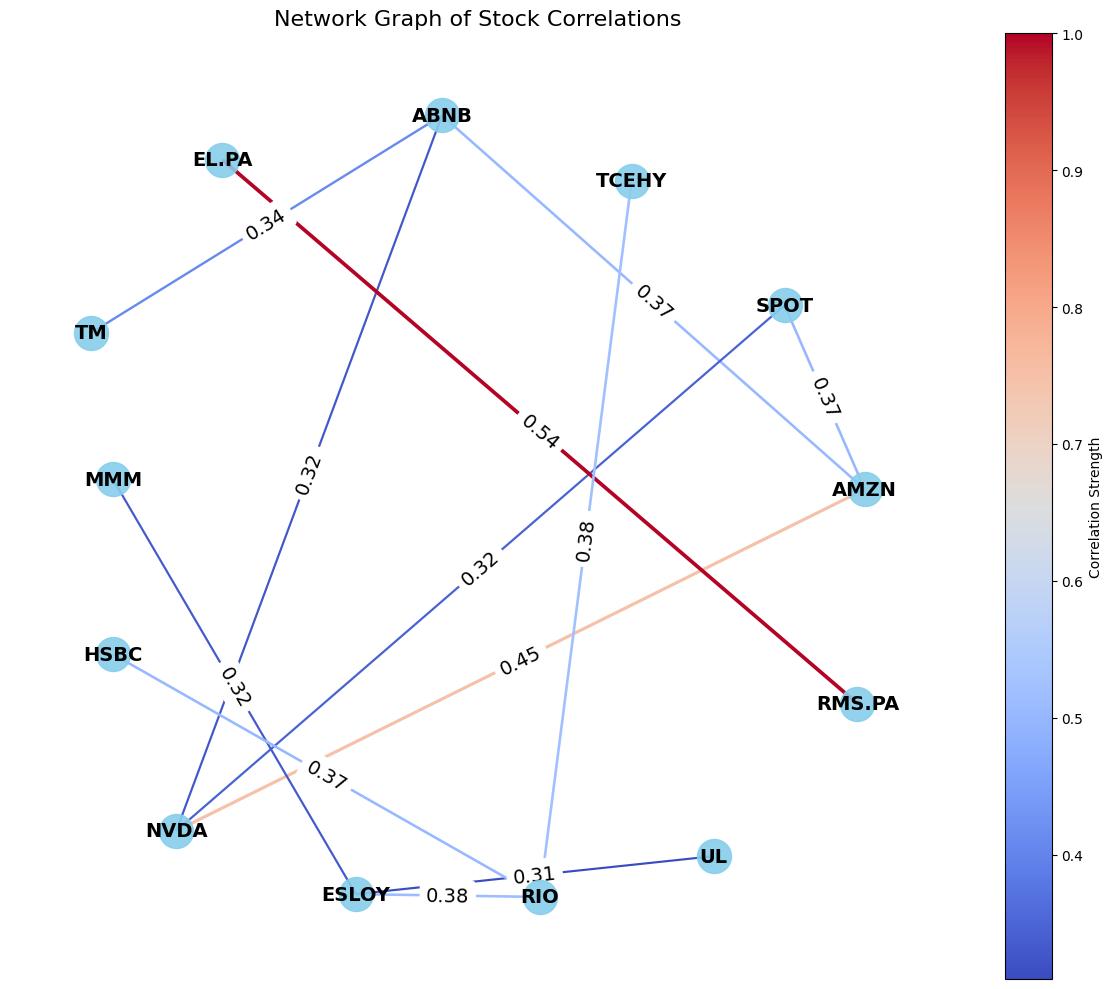

In [82]:
# Create a network graph from the correlation matrix
create_graph_from_correlation(corr_matrix)